# **RNN을 이용한 자연어 처리**

---
- 참고도서
  - 파이토치로 배우는 자연어처리 (델립라오, 브라이언 맥머핸 지음 / 박해선 옮김 | 한빛미디어)
  - 텐서플로 2와 머신러닝으로 시작하는 자연어 처리  (전창욱, 최태균, 조종현, 신성진 지음 | 위키북스)
  - 처음 배우는 딥러닝 챗봇 (조경래 지음 | 한빛미디어)
---

### PyTorch

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.optim as optim 

sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float


"""
Word Processing
"""

word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i : w for i, w in enumerate(word_list)}
n_class = len(word_dict )

In [9]:
" ".join(sentences)

'i like dog i love coffee i hate milk you like cat you love milk you hate coffee'

In [6]:
word_list

['you', 'dog', 'like', 'cat', 'coffee', 'love', 'hate', 'i', 'milk']

In [10]:
word_dict

{'you': 0,
 'dog': 1,
 'like': 2,
 'cat': 3,
 'coffee': 4,
 'love': 5,
 'hate': 6,
 'i': 7,
 'milk': 8}

In [11]:
number_dict

{0: 'you',
 1: 'dog',
 2: 'like',
 3: 'cat',
 4: 'coffee',
 5: 'love',
 6: 'hate',
 7: 'i',
 8: 'milk'}

In [12]:
"""
TextRNN Parameter
"""
batch_size = len(sentences)
n_step = 2  # 학습 하려고 하는 문장의 길이 - 1
n_hidden = 5  # 은닉층 사이즈

def make_batch(sentences) :
    input_batch = [] 
    target_batch = []
    
    for sen in sentences :
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]

        input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
        target_batch.append(target)
        
    return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

In [29]:
input_batch

tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.]]], requires_grad=True)

In [31]:
"""
TextRNN
""" 

class TextRNN(nn.Module) :
    def __init__(self) :
        super(TextRNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)
        
    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.rnn(X, hidden)
        outputs = outputs[-1]  # 최종 예측 Hidden Layer
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return model

In [34]:
"""
Training
"""
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
  hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  output = model(hidden, input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

Epoch: 0100 cost = 0.346302
Epoch: 0200 cost = 0.075040
Epoch: 0300 cost = 0.031197
Epoch: 0400 cost = 0.017341
Epoch: 0500 cost = 0.011139
[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['dog', 'coffee', 'milk', 'cat', 'milk', 'coffee']


### Tensorlow 

In [35]:
"""
어휘 사이즈는 1000, 은닉 벡터 사이즈는 64로 설정
RNN 내부 유닛은 128개, 출력 클래스의 개수는 10개로 설정
"""
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 89,994
Trainable params: 89,994
Non-trainable params: 0
_________________________________________________________________


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN

In [37]:
# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_idx = i + step
        if end_idx > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)

In [38]:
# sin 함수 학습 데이터
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [np.sin(i) for i in x]

In [39]:
# 하이퍼파라미터
n_timesteps = 15
n_features = 1

In [40]:
# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))

shape x:(185, 15) / y:(185,)


In [41]:
#RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


In [42]:
# RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(units=10, return_sequences=False, input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [43]:
# 모델 학습
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='auto')
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 3s 190ms/step - loss: 0.7238
Epoch 2/1000
6/6 [==============================] - 1s 133ms/step - loss: 0.4886
Epoch 3/1000
6/6 [==============================] - 1s 136ms/step - loss: 0.3154
Epoch 4/1000
6/6 [==============================] - 1s 204ms/step - loss: 0.2161
Epoch 5/1000
6/6 [==============================] - 1s 219ms/step - loss: 0.1627
Epoch 6/1000
6/6 [==============================] - 1s 178ms/step - loss: 0.1320
Epoch 7/1000
6/6 [==============================] - 1s 173ms/step - loss: 0.1097
Epoch 8/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0911
Epoch 9/1000
6/6 [==============================] - 1s 152ms/step - loss: 0.0743
Epoch 10/1000
6/6 [==============================] - 1s 168ms/step - loss: 0.0595
Epoch 11/1000
6/6 [==============================] - 1s 159ms/step - loss: 0.0458
Epoch 12/1000
6/6 [==============================] - 1s 240ms/step - loss: 0.0350
Epoch 13/1000
6/6 [======

6/6 [==============================] - 1s 166ms/step - loss: 1.9932e-04
Epoch 100/1000
6/6 [==============================] - 1s 160ms/step - loss: 1.7972e-04
Epoch 101/1000
6/6 [==============================] - 1s 162ms/step - loss: 1.7367e-04
Epoch 102/1000
6/6 [==============================] - 1s 184ms/step - loss: 1.7221e-04
Epoch 103/1000
6/6 [==============================] - 1s 171ms/step - loss: 1.5958e-04
Epoch 104/1000
6/6 [==============================] - 1s 158ms/step - loss: 1.5040e-04
Epoch 105/1000
6/6 [==============================] - 1s 152ms/step - loss: 1.4759e-04
Epoch 106/1000
6/6 [==============================] - 1s 160ms/step - loss: 1.4094e-04
Epoch 107/1000
6/6 [==============================] - 1s 160ms/step - loss: 1.3397e-04
Epoch 108/1000
6/6 [==============================] - 1s 159ms/step - loss: 1.2858e-04
Epoch 109/1000
6/6 [==============================] - 1s 183ms/step - loss: 1.2465e-04
Epoch 110/1000
6/6 [==============================] - 1s 1

6/6 [==============================] - 1s 154ms/step - loss: 4.5136e-05
Epoch 194/1000
6/6 [==============================] - 1s 153ms/step - loss: 4.3873e-05
Epoch 195/1000
6/6 [==============================] - 1s 163ms/step - loss: 4.3338e-05
Epoch 196/1000
6/6 [==============================] - 1s 174ms/step - loss: 4.2941e-05
Epoch 197/1000
6/6 [==============================] - 1s 182ms/step - loss: 4.2103e-05
Epoch 198/1000
6/6 [==============================] - 1s 161ms/step - loss: 4.2267e-05
Epoch 199/1000
6/6 [==============================] - 1s 154ms/step - loss: 4.1702e-05
Epoch 200/1000
6/6 [==============================] - 2s 259ms/step - loss: 4.0852e-05
Epoch 201/1000
6/6 [==============================] - 1s 181ms/step - loss: 4.0895e-05
Epoch 202/1000
6/6 [==============================] - 1s 162ms/step - loss: 4.0920e-05
Epoch 203/1000
6/6 [==============================] - 1s 155ms/step - loss: 4.0785e-05
Epoch 204/1000
6/6 [==============================] - 1s 1

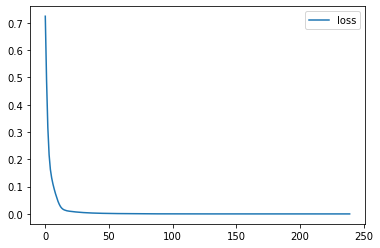

In [44]:
# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

In [45]:
# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

In [46]:
# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
    net_input = test_y[i : i + n_timesteps]
    net_input = net_input.reshape((1, n_timesteps, n_features))
    train_y = model.predict(net_input, verbose=0)
    print(test_y.shape, train_y.shape, i, i + n_timesteps)
    test_y = np.append(test_y, train_y)

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

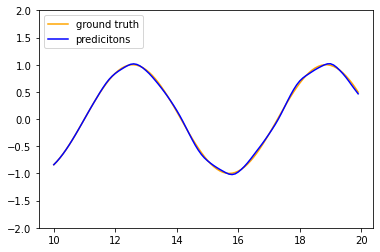

In [47]:
# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predicitons", color="blue")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()